# Assignment 7

In this assignment, we'll use our two variational inference algorithms, and compare their speed and output to MCMC.

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. Your work will be manually graded by our TA. 


In [1]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

### Problem 1: A Derivation

In lecture it was mentioned that the KL-divergence is an intractable quantity. However, the **Evidence Lower Bound (ELBO)**  is usually not. Your goal is to show that this.

Show

\begin{align*}
\text{KL}(g || p) 
&= - \mathbb{E}_{g}\left[ \log\frac{  L(y  \mid \theta) \pi(\theta \mid y)}{g(\theta \mid \phi)} \right] +  \text{constant}  
\end{align*}

Or in other words, show that  the ELBO--the expectation without the negative sign on the right hand side--doesn't involve the unknown normalizing constant $p(y)$.

$$
\text{KL}(g || p) = \int g(\theta \mid \phi) \log \frac{g(\theta \mid \phi)}{p(\theta \mid y)} \, d\theta
$$

Expanding $ p(\theta \mid y) $ using Bayes' theorem:

$$
p(\theta \mid y) = \frac{L(y \mid \theta) \pi(\theta)}{p(y)}
$$

Substitute this into the KL-divergence expression:

$$
\text{KL}(g || p) = \int g(\theta \mid \phi) \log \frac{g(\theta \mid \phi)}{\frac{L(y \mid \theta) \pi(\theta)}{p(y)}} \, d\theta
$$

Simplifying the logarithm term:

$$
\text{KL}(g || p) = \int g(\theta \mid \phi) \left( \log g(\theta \mid \phi) - \log L(y \mid \theta) - \log \pi(\theta) + \log p(y) \right) \, d\theta
$$

Since $ \log p(y) $ is constant with respect to $ \theta $, it can be taken outside the integral:

$$
\text{KL}(g || p) = \int g(\theta \mid \phi) \log g(\theta \mid \phi) \, d\theta - \int g(\theta \mid \phi) \log L(y \mid \theta) \, d\theta - \int g(\theta \mid \phi) \log \pi(\theta) \, d\theta + \log p(y) \int g(\theta \mid \phi) \, d\theta
$$

Because $ g(\theta \mid \phi) $ is a probability distribution, its integral over all $ \theta $ is 1:

$$
\int g(\theta \mid \phi) \, d\theta = 1
$$

Therefore, the term involving $ \log p(y) $ simplifies to:

$$
\log p(y) \cdot 1 = \log p(y)
$$

So we have:

$$
\text{KL}(g || p) = \int g(\theta \mid \phi) \log g(\theta \mid \phi) \, d\theta - \int g(\theta \mid \phi) \log L(y \mid \theta) \, d\theta - \int g(\theta \mid \phi) \log \pi(\theta) \, d\theta + \log p(y)
$$

Recognizing that the first three terms together form the negative Evidence Lower Bound (ELBO):

$$
\text{KL}(g || p) = - \mathbb{E}_{g} \left[ \log \frac{L(y \mid \theta) \pi(\theta)}{g(\theta \mid \phi)} \right] + \log p(y)
$$

Hence, the ELBO is:

$$
\text{ELBO} = \mathbb{E}_{g} \left[ \log \frac{L(y \mid \theta) \pi(\theta)}{g(\theta \mid \phi)} \right]
$$

This does not involve the unknown normalizing constant $ p(y) $.

### Problem 2: Multinomial Regression

Bayes' theorem looks a little different with supervised learning. First, data is split up into predictors (i.e. $x$) and dependent variables (call them $y$). In this example, we will also call our parameters $\beta$, instead of $\theta$. 

So, Bayes' rule will look like this

$$
\pi(\beta \mid y, x) \propto L(y \mid \beta, x) \pi(\beta)
$$


1.

Prove the above using rules of conditioning and any other required assumptions. Attach a screenshot of your deriation to this notebook. 



### Proof:

1. **Bayes' Theorem**:

   Recall the standard form of Bayes' theorem:

   $$
   p(\theta \mid \text{data}) = \frac{p(\text{data} \mid \theta) p(\theta)}{p(\text{data})}
   $$

2. **Identify Terms**:

   In the context of supervised learning, we have:
   - $\theta$ (parameters) replaced by $\beta$
   - Data split into $x$ (predictors) and $y$ (dependent variables)

   Thus, the posterior distribution is:

   $$
   \pi(\beta \mid y, x)
   $$

   The likelihood function is:

   $$
   L(y \mid \beta, x) = p(y \mid \beta, x)
   $$

   The prior distribution is:

   $$
   \pi(\beta) = p(\beta)
   $$

   The marginal likelihood (or evidence) is:

   $$
   p(y \mid x)
   $$

3. **Applying Bayes' Theorem**:

   Applying Bayes' theorem in this context gives:

   $$
   \pi(\beta \mid y, x) = \frac{p(y \mid \beta, x) p(\beta)}{p(y \mid x)}
   $$

4. **Proportionality**:

   The marginal likelihood $p(y \mid x)$ is a normalizing constant that ensures the posterior distribution $\pi(\beta \mid y, x)$ integrates to 1. Since it does not depend on $\beta$, we can express the posterior distribution up to a proportionality constant as:

   $$
   \pi(\beta \mid y, x) \propto p(y \mid \beta, x) p(\beta)
   $$

5. **Rewrite in Terms of $\pi$ and $L$**:

   Rewriting $p(y \mid \beta, x)$ as the likelihood function $L(y \mid \beta, x)$ and $p(\beta)$ as the prior $\pi(\beta)$, we obtain:

   $$
   \pi(\beta \mid y, x) \propto L(y \mid \beta, x) \pi(\beta)
   $$

Thus, we have proven that:

$$
\pi(\beta \mid y, x) \propto L(y \mid \beta, x) \pi(\beta)
$$

This completes the proof that Bayes' theorem in the context of supervised learning (multinomial regression) gives us the posterior distribution as proportional to the product of the likelihood and the prior distribution.

Previously, we modeled categorical output with a multinomial distribution. Our previous notation for one row of data was as follows:

Let $y = (y_1, y_2, \ldots, y_k)$ be a vector of counts.

We assume that there is a known total count (which means $\sum_i y_i = n$). 

A special case of the multinomial distribution--when $\sum_i y_i$ is $1$--is the **Categorical Distribution**. 

This was just like the distinction between Bernoulli and Binomial random variables. A Bernoulli is when there is one trial, and a Binomial is when there are many. Here it is the same. A Categorical random variable is when there is only one trial, and a multinomial is more general and allows for multiple trails. Each trial here, though, each categorical realization, can have multiple outcomes!

Because there is only one trial for each categorical realization, there are multiple ways to represent it ina program. 

One way is the **one-hot-encoding**. It matches the notation that we were using above. We could represent each realization as a length $k$ vector, and only allow one of the elements to be $1$ (or "hot").

A more memory-efficient way is to just store the index/number of the category that took place (e.g. $3$). That's what we are doing with our data set. This way, we only need one column to store the dependent data.

2.

Suppose each message on a social media platform can have four possible sentiments: "outrage", "joking", "intrigued" and "bored". Suppose you are looking at three tweets. The first is outrage, the second is bored, and the third is intrigued. 

Write out two ways that you could represent this data. Describe your category ordering and index labeling. Does your counting start from $1$ or $0$. Are your categories ordered alphabetically? Use the one-hot encoding as well as the simple category labels.  Attach a screenshot of your deriation to this notebook. 

------

There are two approaches we could employ here, I'll start with the One-Hot-Encoding

For a One-Hot-Encoding approach we would build a tabel with a row for each tweet and a column representing each of the four categories "outrage", "joking", "intrigued", and "bored". Each record would have a 1 in exactly one of these columns denoting which category it is. This is a simple approach that somewhat explodes the category out into individual vectors per record and is not very memory efficient. Here is an example of this layout. 

Example: 

| Tweet  | Outrage | Joking | Intrigued | Bored |
|--------|---------|--------|-----------|-------|
| 1      | 1       | 0      | 0         | 0     |
| 2      | 0       | 0      | 0         | 1     |
| 3      | 0       | 1      | 0         | 0     |
| 4      | 0       | 0      | 1         | 0     |

For a simpler index approach we would simply assign 0-3 to each of the categories. So, 0 = Outrage, 1 = Joking, 2 = Intrigued, and 3 = Bored. Now we only need 1 vector to contain all of the category information for every tweet. This is a more rational approach but can have problems with other kinds of ML approaches. 

Example: 

| Tweet  | Category |
|--------|----------|
| 1      | 0        |
| 2      | 3        |
| 3      | 2        |
| 4      | 1        |


The ordering and assigning of the indices is somewhat domain specific, but for simplicity something like alphabetical or order of sentiments might make sense. Happy -> Sad 

------

Previously, our data were so simplistic that we assumed each observation--each row of data (usually)--was from the same distribution. In other words, the probabilities of each "bucket" stay the same. We wrote it like this

Let $\theta = (\theta_1, \theta_2, \ldots, \theta_k)$ be the probabilities of any trial resulting in each of the $k$ outcomes. 

We also assume the only possible outcomes are these $k$ outcomes so $\sum_i \theta_i = 1$.

One way we can generalize this model is to allow the probabilities to vary. We could let them be affected by predictors. That's what we'll do in this homework. We will take our predictors, multiple them with some parameters, then use a nonlinear function to get the probabilities for each bucket. 

**Please note that we will describe the details of this model in more detail in a future module!**



Here is our high-level notation:

 - $N$: the number of observations/rows we have
 - $i$: the row number...goes from $1$ to $N$
 - $K$: number of categories/buckets we try to predict
 - $y_i$: the categorical dependent variable in row $i$ (it can be $1, \ldots, K$)
 - $y$ is the set of all $y_1, \ldots, y_N$
 - $D$: the number of predictors we can use to inform bucket probabilities
 - $x_i$: the row of predictor information. It has length $D$
 - $x$ is the matrix of all row predictors. It has shape $N \times D$

To drive this home, let's look at our specific data set, and try to make it look like this notation. 

In [2]:
d = pd.read_csv("SoftmaxRegData1.csv")
y = d['Y']
x = d[['X1','X2']].assign(intercept=1)
print(y.head())
print("\n\nunique y values: ", np.unique(y), "\n\n")
x.head()

0    2
1    1
2    3
3    3
4    3
Name: Y, dtype: int64


unique y values:  [1 2 3 4] 




,X1,X2,intercept
0,-0.087147,-1.081342,1
1,-0.722566,-1.583863,1
2,0.179190,0.971790,1
3,-1.159752,0.502624,1
4,-0.727118,1.375704,1


Our parameters of the model are "weights" that we weight predictors by. 

For parsimony, we use the same weights for each row of data. 

Also, each column of $\beta$ will take data an give a probability output *for each possible outcome.* 

This makes the weight matrix $\beta$ a $D \times K$. For us, that's $3 \times 4$.

We can write our likelihood in a few different ways.

$$
L(y \mid x, \beta) = \prod_{i=1}^N L(y_i \mid x_i, \beta)
$$
and
$$
L(y_i \mid x_i, \beta) = \text{Categorical}(\text{softmax}(x_i ^\intercal \beta) )
$$

**We will discuss the softmax function more later.** Suffice it to say that $\text{softmax}(x_i ^\intercal \beta)$ is a column vector of probabilities. Each probability describes the chances of each possible outome of the dependent variable $y_i$. Further, these probabilities depend on data for that particular row. They were kind of like our $\theta$s from before, but they now depend on the data we have in a particular row.

2.

I have provided a `.stan` file called `multinomial_regression.stan` that describes the model above. Take a look at it, and observe how it maps to the above description of the model. After you are comfortable with it, build your model into an object called `model`.


In [4]:
model = CmdStanModel(stan_file="./multinomial_regression.stan")

16:58:15 - cmdstanpy - INFO - compiling stan file /bml24/assignment7/multinomial_regression.stan to exe file /bml24/assignment7/multinomial_regression
16:58:57 - cmdstanpy - INFO - compiled model executable: /bml24/assignment7/multinomial_regression


3. 

Use NUTS the MCMC algorithm to draw samples from this posterior. 

Do all the $\hat{R}$s look good for each parameter? What are your parameter estimates? What are 90% credible intervals for those parameter estimates? Don't worry about writing too much...just call `.summary()` in a cell.

Which parameters are very correlated (a posteriori) and how so? Why do you think is this the case? Justify your answer. Use `pd.plotting.scatter_matrix()` to visualize all the pairwise correlations of the posterior samples. 

In [6]:
our_data = {
    "K": 4,
    "N": x.shape[0],
    "D": 3,
    "y": y,
    "x": x
}
fit = model.sample(data=our_data)

17:02:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:03:06 - cmdstanpy - INFO - CmdStan done processing.


In [24]:
#RHat's look good! Confidence intervials decently tight!
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-166.555000,0.067181,2.46275,-171.116000,-166.167000,-163.196000,1343.84,19.1545,1.00022
"beta[1,1]",-4.647080,0.072414,2.56025,-8.826180,-4.708460,-0.421306,1250.05,17.8176,1.00093
"beta[1,2]",0.808762,0.072127,2.55682,-3.451680,0.788820,5.077290,1256.61,17.9112,1.00079
"beta[1,3]",-3.889710,0.071980,2.56129,-8.040790,-3.951790,0.341350,1266.18,18.0476,1.00057
"beta[1,4]",7.350140,0.072331,2.59503,3.107500,7.354980,11.661600,1287.19,18.3470,1.00039
"beta[2,1]",-2.554140,0.058100,2.45656,-6.578070,-2.582160,1.504480,1787.70,25.4811,1.00068
"beta[2,2]",-1.725950,0.058590,2.43910,-5.639510,-1.761480,2.366110,1733.05,24.7021,1.00082
"beta[2,3]",3.324070,0.059157,2.46261,-0.633221,3.292820,7.424520,1732.90,24.7000,1.00074
"beta[2,4]",0.954936,0.058738,2.44751,-3.019600,0.923438,5.042080,1736.25,24.7477,1.00066
"beta[3,1]",-1.250820,0.067015,2.58631,-5.503310,-1.287530,3.041430,1489.44,21.2298,1.00183


In [41]:
posterior_samples = (fit.draws_pd())

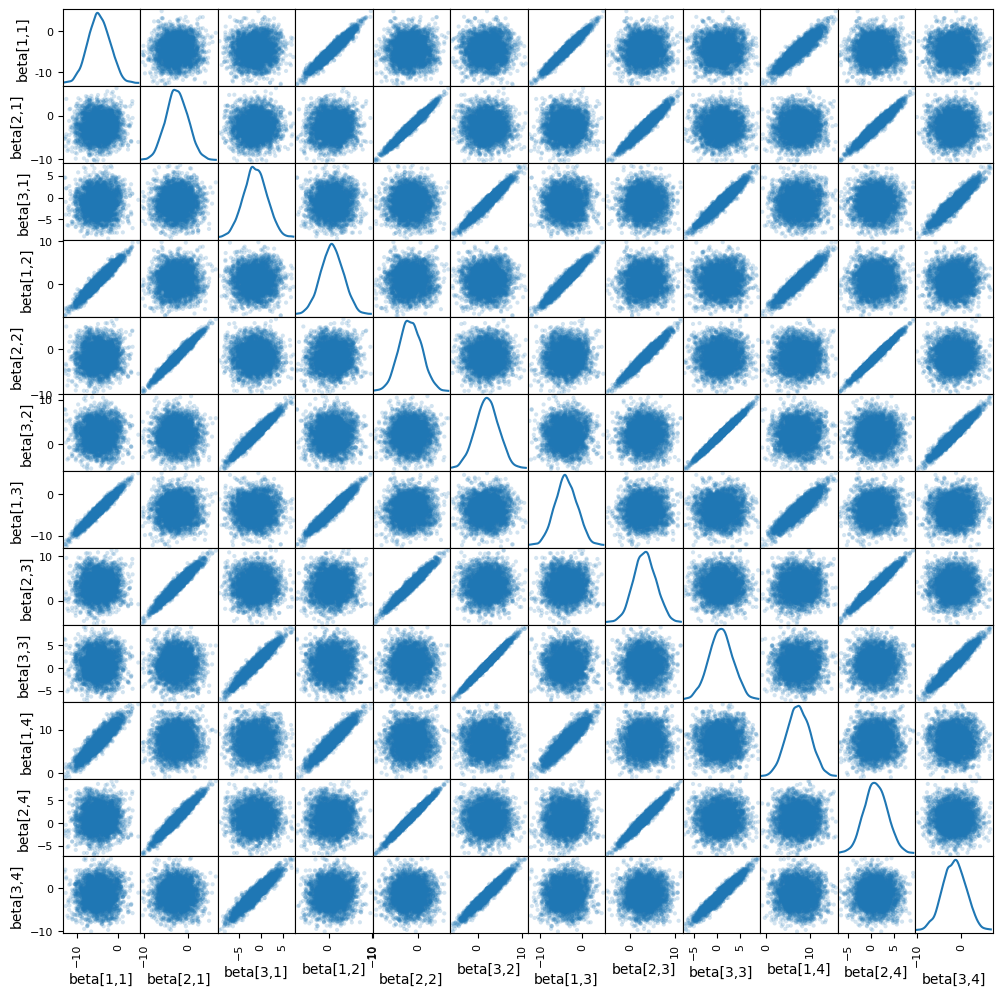

In [48]:
param_names = [
    'beta[1,1]', 'beta[2,1]', 'beta[3,1]', 
    'beta[1,2]', 'beta[2,2]', 'beta[3,2]', 
    'beta[1,3]', 'beta[2,3]', 'beta[3,3]', 
    'beta[1,4]', 'beta[2,4]', 'beta[3,4]'
]

posterior_samples_params = posterior_samples[param_names]

pd.plotting.scatter_matrix(posterior_samples_params, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

# Decent count of postiive correlations, it seems like all of the parameters that share a dimension with another parameter were somewhat correlated, so 3,2 with 3,? etc. It is likely that this is because the parameters are related to the same categories, so are more highly correlated, parameters that do not share the same category likely lack this high correlation.

4. 

Use Pathfinder VI algorithm to obtain a posterior approximation. 

Are the parameter estimates close to the MCMC parameter estimates? 

Was it much faster than the MCMC sampler?

Which parameters are very correlated (a posteriori) and how so? Why do you think is this the case? Use `pd.plotting.scatter_matrix()` to visualize all the pairwise correlations of the posterior samples. 

In [49]:
# Notably faster, practically instant

fit2 = model.pathfinder(data=our_data)

17:43:43 - cmdstanpy - INFO - Chain [1] start processing
17:43:43 - cmdstanpy - INFO - Chain [1] done processing


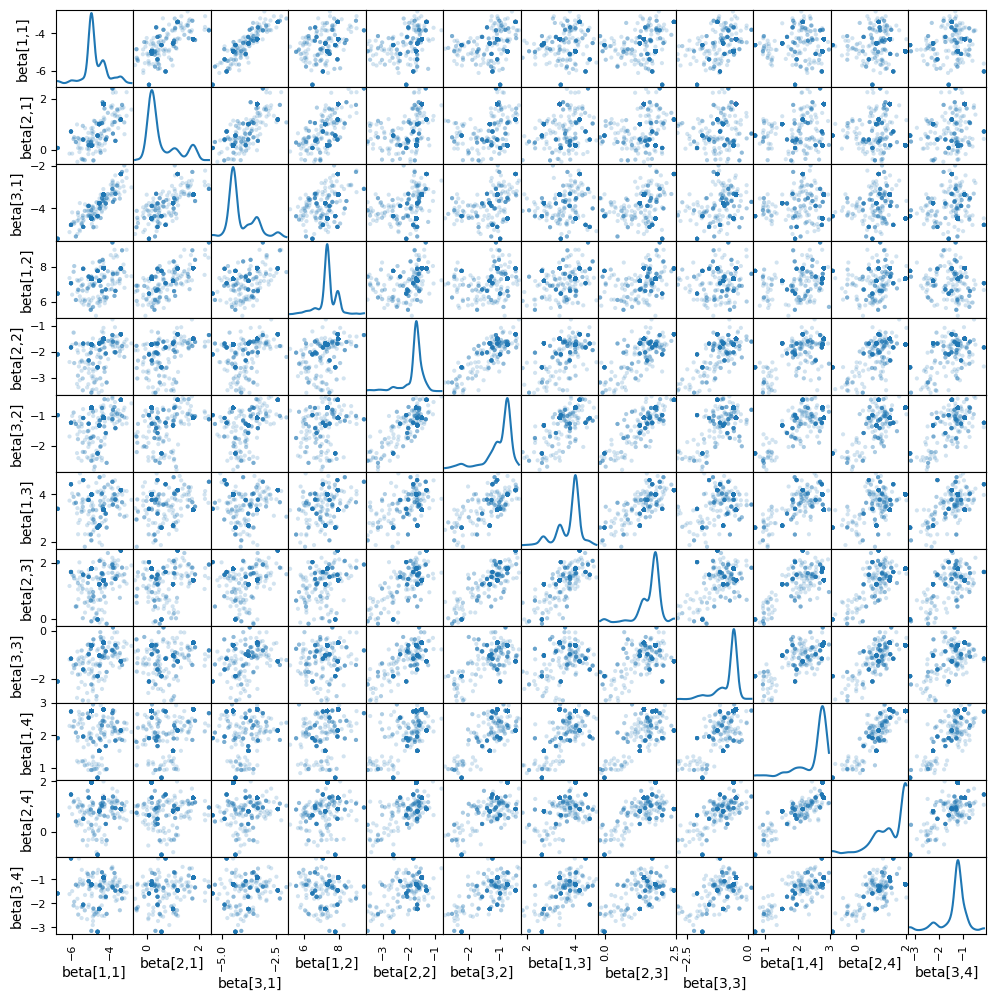

In [102]:
# Notably less confident, correlations still visible but hardly as obviously positive. Pairwse correlations corresponding to categories are still more positive but certainly less so.

beta_estimates = fit2.stan_variable("beta")
num_samples, num_params, num_categories = beta_estimates.shape
reshaped_beta_estimates = beta_estimates.reshape((num_samples, num_params * num_categories))

param_names = [
    'beta[1,1]', 'beta[2,1]', 'beta[3,1]', 
    'beta[1,2]', 'beta[2,2]', 'beta[3,2]', 
    'beta[1,3]', 'beta[2,3]', 'beta[3,3]', 
    'beta[1,4]', 'beta[2,4]', 'beta[3,4]'
]

df_beta_estimates = pd.DataFrame(reshaped_beta_estimates, columns=param_names)

pd.plotting.scatter_matrix(df_beta_estimates, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

5. 

Use the ADVI algorithm to obtain a posterior approximation. 

Are the parameter estimates close to the pathfinder's estimates?

Was it much faster than the MCMC sampler?

Which parameters are very correlated (a posteriori) and how so? Why do you think is this the case? Use `pd.plotting.scatter_matrix()` to visualize all the pairwise correlations of the posterior samples. 

In [82]:
#similar to the above, very fast

fit3 = model.variational(data=our_data)

18:35:26 - cmdstanpy - INFO - Chain [1] start processing
18:35:26 - cmdstanpy - INFO - Chain [1] done processing


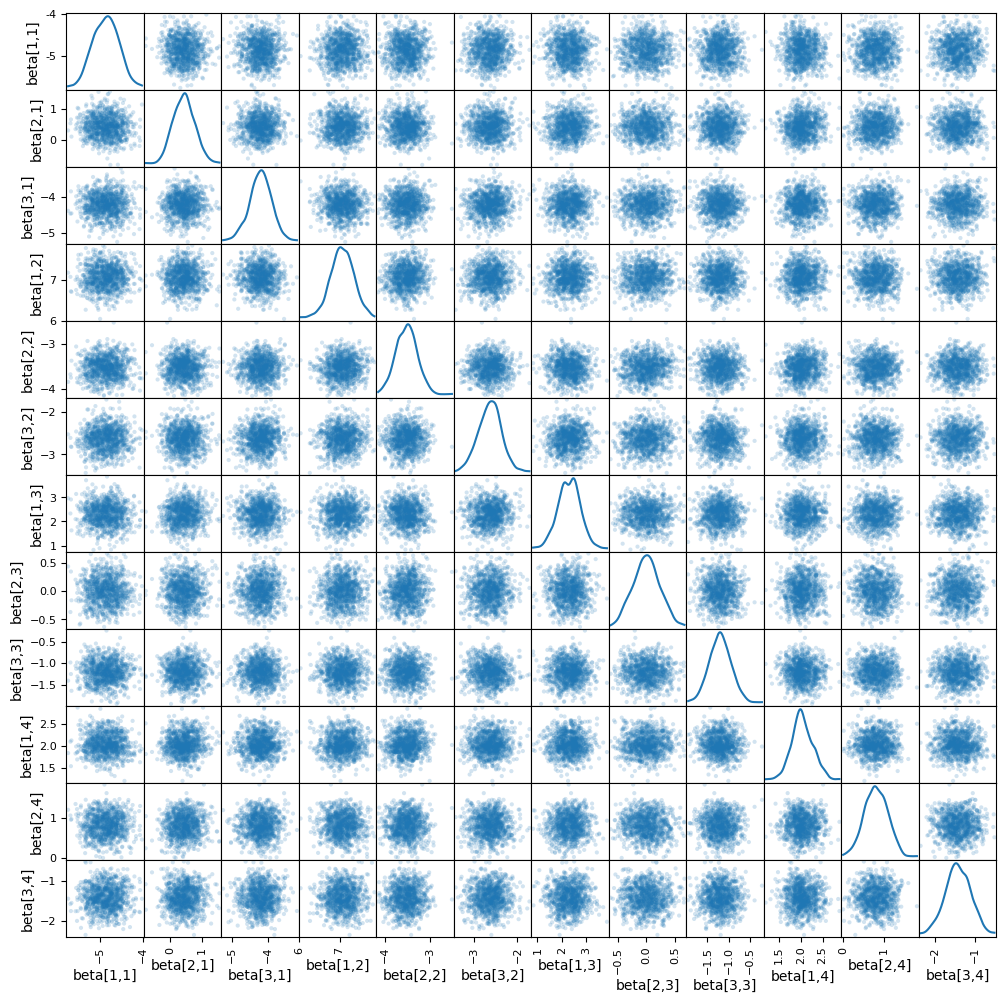

In [103]:
# Variational shows significantly less in the way of parameter correlations, pathfinder was weak but this is definitely the lowest we've seen, maybe very slight correlations but nothing confident here
# This is likely because of the implementation of VI and some of the assumptions made within causing the approach to fail to capture these pairwise relationships as well. The goal for the model 
# is to optimize the ELBO metric, not capture correlations after all.


beta_estimates = fit3.stan_variable("beta", mean=False)

num_samples, num_params, num_categories = beta_estimates.shape
reshaped_beta_estimates = beta_estimates.reshape((num_samples, num_params * num_categories))

param_names = [
    'beta[1,1]', 'beta[2,1]', 'beta[3,1]', 
    'beta[1,2]', 'beta[2,2]', 'beta[3,2]', 
    'beta[1,3]', 'beta[2,3]', 'beta[3,3]', 
    'beta[1,4]', 'beta[2,4]', 'beta[3,4]'
]

df_beta_estimates = pd.DataFrame(reshaped_beta_estimates, columns=param_names)

pd.plotting.scatter_matrix(df_beta_estimates, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

6.

Describe two different approaches on how to simulate from the posterior predictive distribution. Why is this more interesting than simulating from the posterior preditive of our other models? 

Hint: did we make any modeling assumptions for the predictor data?

# Method 1: MCMC and NUTS

This method of simulating from the posterior predictive distribution is powerful but can be slow. Instead of directly solving for the complex integral over $p(y)$, we use clever sampling techniques like NUTS (No-U-Turn Sampler) to avoid having to calculate that integral directly. This is more interesting than other sampling techniques because it allows for dramatically more complicated models where calculating that normalizing constant might be infeasible.

# Method 2: ADVI and Pathfinder

This method of simulating from the posterior predictive distribution is fast and lightweight. It approximates the posterior distribution parameters and is optimized using the Evidence Lower Bound (ELBO) method, which seeks to minimize the distance between an approximating distribution $g$ and the actual posterior distribution. This method is interesting because it allows us to sample from higher-dimensional and more complex distributions more efficiently compared to MCMC methods. However, while it is generally faster, it may not always capture the full complexity of the posterior as accurately as MCMC.

# Method 3: Simple Models
This method relies on using conjugate priors and other simplifications to allow for direct analytical evaluation of the posterior distribution. It is less popular for complex models because it requires the ability to evaluate the normalizing constant and may not be applicable to all models. However, for models where this is possible, it provides exact results and can be very efficient. This approach guarantees maximum accuracy for the posterior and posterior predictive distributions when the model assumptions hold.